<center> <b> <font size="3"> <font color="green">rfborg </font>:
    you will be assimilated— resistance is futile! </font> </b> </center> 

In [1]:
import os
from pynq import Overlay
from pynq import Xlnk
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal

In [7]:
# FIRMWARE UPLOAD
firmware = Overlay('full_speed_v4.bit')
# INITIALIZING LMK04208 CLOCK
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

[  10.           10.24512256   10.49024512 ...,  499.50975488  499.75487744
  500.        ]


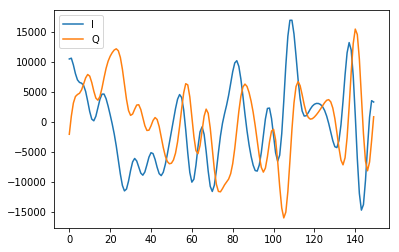

In [3]:
# Generating DAC Waveform
addr_size=11
channels=16
data_p = channels*2**(addr_size) # 21 # length of timestream or length of LUT+1
fs = 4096.0e6 # sampling rate of D/A, FPGA fabric = fs/2
C=1 # decimation factor
# #####################################################
# # SET FREQ
# #####################################################
N=2000
freqs = np.linspace(10e6,500e6,N)*C
psi=np.arange(-np.pi,np.pi,.0001)
#freqs = np.arange(10e6,501e6,10e6)*C
print(freqs/1e6)
A = 2**15-1 # 16 bit D/A, expecting signed values.
freq_res = fs/data_p # Hz
# #####################################################
# # IQ balancing
# s1 = 1.0
# s2 = 1.0
pi = np.pi

################################
# GENERATE WAVEFORM FROM FREQ
################################
freqs = np.round(freqs/(freq_res))*freq_res
delta = np.zeros(data_p,dtype="complex") # empty array of deltas
for i in range(len(freqs)):
    bin_num = np.round((freqs[i]/freq_res)).astype('int')
    delta[bin_num] = (1+1j)*np.exp(1j*np.random.choice(psi))#np.random.random(-np.pi,np.pi))
ts = np.fft.ifft(delta, norm="ortho")
I = (ts.real/max(ts.real)*A).astype("int16")
Q = (ts.imag/max(ts.imag)*A).astype("int16")

I0, Q0 =I[0::16], Q[0::16]
I1, Q1 =I[1::16], Q[1::16]
I2, Q2 =I[2::16], Q[2::16]
I3, Q3 =I[3::16], Q[3::16]
I4, Q4 =I[4::16], Q[4::16]
I5, Q5 =I[5::16], Q[5::16]
I6, Q6 =I[6::16], Q[6::16]
I7, Q7 =I[7::16], Q[7::16]
I8, Q8 =I[8::16], Q[8::16]
I9, Q9 =I[9::16], Q[9::16]
I10, Q10 =I[10::16], Q[10::16]
I11, Q11 =I[11::16], Q[11::16]
I12, Q12 =I[12::16], Q[12::16]
I13, Q13 =I[13::16], Q[13::16]
I14, Q14 =I[14::16], Q[14::16]
I15, Q15 =I[15::16], Q[15::16]

Is = [I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15]
Qs = [Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15]
Z = []
Y = []
for i in range(len(Is)//2):
    Z_val = (np.int64(Is[2*i+1]) << 16) + Is[2*i]
    Y_val = (np.int64(Qs[2*i+1]) << 16) + Qs[2*i]
    Z.append(Z_val.astype("int32"))
    Y.append(Y_val.astype("int32"))
plt.figure()
#plt.plot(I0[0:50],label="I0")
#plt.plot(I1[0:50],label="I1")
#plt.plot(I2[0:50],label="I2")
plt.plot(I[0:150],label="I")
plt.plot(Q[0:150],label="Q")
#plt.plot(Z[0][0:100],label="Z")
plt.legend()
plt.show()

In [8]:
bram_i0 = firmware.dac_i.dac_i0i1.BRAM_SNAPII_0
bram_i1 = firmware.dac_i.dac_i2i3.BRAM_SNAPII_0
bram_i2 = firmware.dac_i.dac_i4i5.BRAM_SNAPII_0
bram_i3 = firmware.dac_i.dac_i6i7.BRAM_SNAPII_0
bram_i4 = firmware.dac_i.dac_i8i9.BRAM_SNAPII_0
bram_i5 = firmware.dac_i.dac_i10i11.BRAM_SNAPII_0
bram_i6 = firmware.dac_i.dac_i12i13.BRAM_SNAPII_0
bram_i7 = firmware.dac_i.dac_i14i15.BRAM_SNAPII_0
bram_q0 = firmware.dac_q.dac_q0q1.BRAM_SNAPII_0
bram_q1 = firmware.dac_q.dac_q2q3.BRAM_SNAPII_0
bram_q2 = firmware.dac_q.dac_q4q5.BRAM_SNAPII_0
bram_q3 = firmware.dac_q.dac_q6q7.BRAM_SNAPII_0
bram_q4 = firmware.dac_q.dac_q8q9.BRAM_SNAPII_0
bram_q5 = firmware.dac_q.dac_q10q11.BRAM_SNAPII_0
bram_q6 = firmware.dac_q.dac_q12q13.BRAM_SNAPII_0
bram_q7 = firmware.dac_q.dac_q14q15.BRAM_SNAPII_0
brams_i = [bram_i0,bram_i1,bram_i2,bram_i3,bram_i4,bram_i5,bram_i6,bram_i7]
brams_q = [bram_q0,bram_q1,bram_q2,bram_q3,bram_q4,bram_q5,bram_q6,bram_q7]

def clear_lut(bram):
    load=2**29
    memlen=(2**11)#-2**8
    bram.write(4,load)
    for i in range(memlen):
        bram.write(0,i<<(32-11)) #write addr
        bram.write(12,0) #write array index to port
    bram.write(4,0)
    
def load_lut(bram,Z):
    inB = 2**29 # | 2**30
    memlen = 2**11
    for i in range(memlen):
        bram.write(4,0)
        bram.write(0,i<<(32-11)) #write addr
        bram.write(12,int(Z[i])) #write array index to port
        bram.write(4,inB)
        bram.write(4,0)

In [9]:
for i in range(len(Z)):
    load_lut(brams_i[i],Z[i])
    load_lut(brams_q[i],Y[i])
    print(i)
#load_lut(bram,Z)

0
1
2
3
4
5
6
7
